# 1. Loading sentence bert

In [1]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

# Using default pretrained max_seq_length for best performance
model = SentenceTransformer('all-mpnet-base-v2')

# 2. Generating embeddings of val dataset

In [2]:
import pandas as pd
from os import path

df_val = pd.read_csv(path.join('data', 'dev.csv'), delimiter='\t')
df_sample_test = pd.read_csv(path.join('data', 'sample_demo.csv'), delimiter='\t')

for df in [df_val, df_sample_test]:
    if 'setence1' in df.columns:
        df.rename(columns={'setence1': 'sentence1'}, inplace=True)
    df['sentence1']= df['sentence1'].astype(str)
    df['sentence2']= df['sentence2'].astype(str)

df_val = df_val[['sentence1', 'sentence2', 'score']] # Reorder columns
df_sample_test = df_sample_test[['sentence1', 'sentence2', 'score']]

embeddings_col_1 = model.encode(df_val.sentence1, show_progress_bar=True)
embeddings_col_2 = model.encode(df_val.sentence2, show_progress_bar=True)

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

# 3. Computing similarity scores
## (scaled to be from 0 to 5)

### Why do we use cos_similarity * 5 instead of (1+cos_similarity) * 2.5?

1. Sentence transformer is pretrained with cosine distance loss on labels that are scaled b/w 0-1.
2. It almost always outputs embeddings that give cosine distance b/w 0 and 1, with a mean of 2.5 in a balanced dataset.
3. It is recommended to be finetuned with data scaled b/w 0 to +1 instead of -1 to +1.

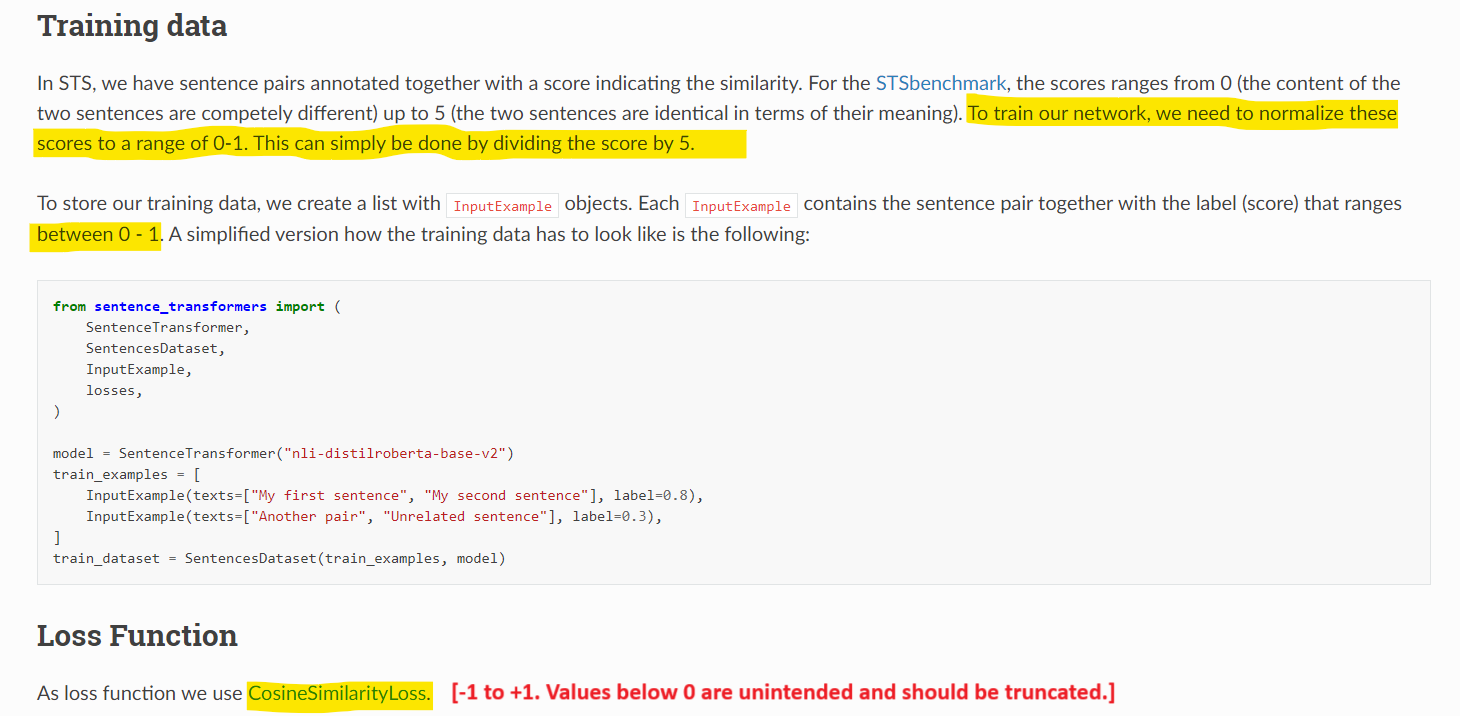

### Regardless, the required metric (Pearson Corr.) is independent of linear transformations on its inputs. So this metric value will be same regardless of which formula is used.
###

In [3]:
from tqdm import tqdm
import numpy as np

predictions = []
df_val_results = df_val.copy()

for embedding_1, embedding_2 in zip(embeddings_col_1, embeddings_col_2):
    cos_distance = cosine(embedding_1, embedding_2)
    cos_similarity = 1-cos_distance
    similarity_scaled = np.clip(cos_similarity * 5, 0, 5)
    predictions.append(round(similarity_scaled, 2))

df_val_results['prediction'] = predictions
df_val_results

sentence1  \
0                     A man with a hard hat is dancing.   
1                      A young child is riding a horse.   
2                  A man is feeding a mouse to a snake.   
3                        A woman is playing the guitar.   
4                         A woman is playing the flute.   
...                                                 ...   
1465            Scientists prove there is water on Mars   
1466  Pranab stresses need to strive for peace by na...   
1467  Volkswagen skids into red in wake of pollution...   
1468  Obama is right: Africa deserves better leadership   
1469  New video shows US police officers beating men...   

                                              sentence2  score  prediction  
0                  A man wearing a hard hat is dancing.   5.00        4.98  
1                            A child is riding a horse.   4.75        4.75  
2              The man is feeding a mouse to the snake.   5.00        4.27  
3                              A man is playing guitar.   2.40        2.97  
4                             A man is playing a flute.   2.75        3.68  
...                                                 ...    ...         ...  
1465                 Has Nasa discovered water on Mars?   2.00        4.00  
1466     WTO: India regrets action of developed nations   0.00        1.55  
1467  Volkswagen's "gesture of goodwill" to diesel o...   2.00        2.37  
1468  Obama waiting for midterm to name attorney gen...   0.00        1.19  
1469  New York police officer critically wounded in ...   0.00        1.91  

[1470 rows x 4 columns]

In [4]:
df_val_results.describe()

score   prediction
count  1470.000000  1470.000000
mean      2.344035     2.808068
std       1.502124     1.380360
min       0.000000     0.000000
25%       1.000000     1.732500
50%       2.400000     3.080000
75%       3.600000     3.940000
max       5.000000     5.000000

# 4. Computing the evaluation metric

In [5]:
import evaluate

pearsonr_metric = evaluate.load("pearsonr")
results = pearsonr_metric.compute(
    predictions=df_val_results['prediction'],
    references=df_val_results['score']
)
print("Pearson correlation:", round(results['pearsonr'], 3))

Pearson correlation: 0.873


# 5. Sample outputs on sample_test.csv

Useful for eyeballing

In [6]:
import numpy as np

df = df_sample_test.copy()
embeddings_col_1 = model.encode(df.sentence1, show_progress_bar=True)
embeddings_col_2 = model.encode(df.sentence2, show_progress_bar=True)

predictions = []

for embedding_1, embedding_2 in zip(embeddings_col_1, embeddings_col_2):
    cos_distance = cosine(embedding_1, embedding_2)
    cos_similarity = 1-cos_distance
    similarity_scaled = np.clip(cos_similarity * 5, 0, 5)
    predictions.append(round(similarity_scaled, 2))

df['prediction'] = predictions
df

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

sentence1  \
0     A man with a hard hat is dancing.   
1      A young child is riding a horse.   
2  A man is feeding a mouse to a snake.   
3        A woman is playing the guitar.   
4         A woman is playing the flute.   
5          A woman is cutting an onion.   

                                  sentence2  score  prediction  
0      A man wearing a hard hat is dancing.  5.000        4.98  
1                A child is riding a horse.  4.750        4.75  
2  The man is feeding a mouse to the snake.  5.000        4.27  
3                  A man is playing guitar.  2.400        2.97  
4                 A man is playing a flute.  2.750        3.68  
5                  A man is cutting onions.  2.615        3.61